# Plot scoring positions

Use model to inference a new map



In [7]:
import fnmatch
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="husl")

2023-05-25 13:26:59,818 - numexpr.utils - INFO - Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-25 13:26:59,823 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Specify Model to test

In [8]:
simple = False
epochs = 12
ipx = True 
dropout = .5
batch_size = 128
# bc_resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
model_name = "ON_resnet18_simpleFalse_IPEXTrue_Epochs40_dropout0.33_batch128"
#resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
#model_name = f"resnet18_simple{simple}_IPEX{ipx}_Epochs{epochs}_dropout{dropout}_batch{batch_size}"
print(model_name)
model_read = torch.jit.load(f"models/{model_name}.pt")

model_read.eval()

ON_resnet18_simpleFalse_IPEXTrue_Epochs40_dropout0.33_batch128


RecursiveScriptModule(
  original_name=FireFinder
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_name=BatchN

# Define functions and normalization parameters

In [9]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

class ImageFolderWithPaths(datasets.ImageFolder):
    """custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)
        return super().__getitem__(index) + paths


def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose
    labels have to be predicted are kept.

    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.

    returns: (
        images: images loaded from disk for inferece,
        yhats: predicted labels
        paths: image file-path on disk        )
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = ImageFolderWithPaths(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=4,
    )
    yhats = []
    images = []
    paths = []
    for (imgs, _, fpaths) in dataloader:
        yhat = model(imgs)
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        paths.extend(fpaths)
        images.extend(imgs.data.cpu())
    return images, yhats, paths

def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=4, figsize=(10, 6)):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(dataloader))  # batch of with images, batch of labels
    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )  # get num_data of images, labels
    plt.style.use("dark_background")
    _, axes = plt.subplots(1, num_data, figsize=figsize)
    for n in range(num_data):
        axes[n].set_title(labels[n])
        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))

def _denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean to show images"""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean

# Prepare final test set

In [10]:
# !mkdir data/ThreeClassManualRemove0s/test
# !mkdir  data/test/unknown
# !cp data/DinosaurNationalMonument/20220514/224/*.jpg data/ThreeClassManualRemove0s/test/unknown/

# Load data

# Inference Given Large Image

In [11]:
import glob
from PIL import Image
from os.path import exists
import os
path = "data/test/unknown/NoFire_089.png"

img = Image.open(path).convert('RGB')
img.size

(1024, 576)

# Simple eval function

In [12]:
from PIL import Image
import torchvision.transforms.functional as TF

def transform_image(image):
    my_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    return my_transforms(image).unsqueeze(0)

def eval_simple(working_slice):
    x = transform_image(working_slice)
    output = model_read(x)
    return output.detach().numpy().argmax()

eval_simple(img)

1

# Read folder of test images and score them

In [13]:
import glob
from PIL import Image
from os.path import exists
import os
fireDict = {0: 'Fire', 1: 'NoFire'}
ytrue = []
ypred = []
for fl in glob.glob('data/test/unknown/*.png'):
    if 'NoFire' in fl:
        ytrue.append(1)
    else:
        ytrue.append(0)
    img = Image.open(fl).convert('RGB')
    score = eval_simple(img)
    ypred.append(score)
    print(fireDict[score], fl)
import time

start = time.time()


NoFire data/test/unknown/NoFire_078.png
Fire data/test/unknown/NoFire_081.png
Fire data/test/unknown/Fire_040.png
Fire data/test/unknown/NoFire_043.png
NoFire data/test/unknown/NoFire_049.png
Fire data/test/unknown/Fire_096.png
Fire data/test/unknown/Fire_043.png
Fire data/test/unknown/Fire_073.png
NoFire data/test/unknown/NoFire_015.png
NoFire data/test/unknown/NoFire_057.png
NoFire data/test/unknown/NoFire_073.png
Fire data/test/unknown/Fire_012.png
Fire data/test/unknown/Fire_081.png
NoFire data/test/unknown/NoFire_040.png
NoFire data/test/unknown/NoFire_089.png
Fire data/test/unknown/Fire_057.png
NoFire data/test/unknown/NoFire_133.png
NoFire data/test/unknown/NoFire_012.png
Fire data/test/unknown/Fire_089.png
Fire data/test/unknown/Fire_078.png
Fire data/test/unknown/Fire_049.png


In [14]:
!ls 'data/test/unknown/' | wc -l

21


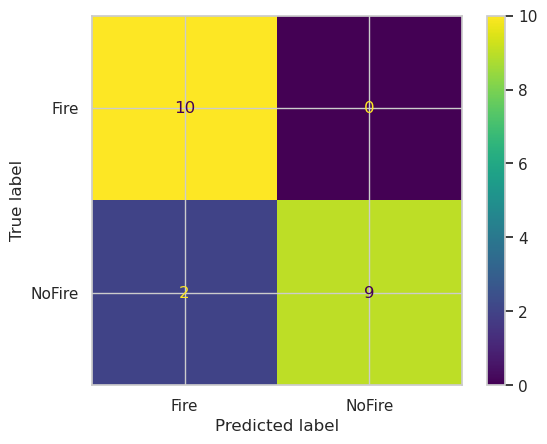

In [15]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
YTRUE = [fireDict[val] for val in ytrue]
YPRED = [fireDict[val] for val in ypred]
labels=['Fire', 'NoFire']
cm = confusion_matrix(YTRUE, YPRED,  labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()

In [16]:
import numpy as np
ParadiseNoFire = np.array((
        [[-121.85993896484375, 39.691345948326905],
         [-121.80500732421875, 39.65435007197939],
         [-121.76655517578125, 39.620507934098555],
         [-121.97529541015625, 39.681834615387814],
         [-121.75556884765625, 39.865488095353165],
         [-121.66630493164062, 39.90974481056605],
         [-121.599013671875, 39.97291911943351],
         [-121.51386962890625, 39.97607630368619],
         [-121.4287255859375, 39.97397153038964],
         [-121.34495483398437, 39.952920232420816],
         [-121.2749169921875, 39.91711815190346],
         [-121.5166162109375, 39.5654791496585],
         [-121.51386962890625, 39.42453364918935],
         [-121.63197265625, 39.408619611696544],
         [-121.81599365234375, 39.37571908969214],
         [-121.92585693359375, 39.41922937368349],
         [-122.07279907226562, 39.639546174127624],
         [-123.86854642948475, 39.89528279436593],
         [-124.00999540409413, 40.0342186293671],
         [-123.96330350956288, 40.16027882735746],
         [-123.88639921268788, 40.19385543181088],
         [-123.92485136112538, 40.00056314355636],
         [-123.80674833378163, 39.82359963181943],
         [-123.75318998417225, 39.72121615770172],
         [-123.7119912537035, 39.60069460850108],
         [-123.68589872440663, 39.512814285258216],
         [-123.52934354862538, 39.54247310342824],
         [-123.58839506229725, 39.723328694540626],
         [-123.66529935917225, 39.89949711891423],
         [-123.75318998417225, 40.0373729801269],
         [-123.85618681034413, 40.10358063803625],
         [-123.72709745487538, 40.21692970887466],
         [-123.65568632206288, 40.16027882735746],
         [-123.60624784550038, 40.02265142834034],
         [-123.508744183391, 39.90687156325932],
         [-123.43046659550038, 39.80355713046257],
         [-123.36180204471913, 39.6990306137821],
         [-123.30961698612538, 39.55729776160525],
         [-123.21074003300038, 39.77401016130511],
         [-123.26567167362538, 39.92161807074487],
         [-123.48814481815663, 40.167625129255825],
         [-123.18876737675038, 39.47678297697318],
         [-123.57054227909413, 39.448156577080454],
         [-121.33977939187842, 39.43718616384962],
         [-121.16399814187842, 39.48807742027464],
         [-121.02117587625342, 39.55799212336968],
         [-120.90581943094092, 39.62572096646533],
         [-120.82616855203467, 39.699723554607615],
         [-120.65038730203467, 39.779979470823044],
         [-120.59820224344092, 39.938104918060766],
         [-120.75201083719092, 39.99494085966642],
         [-120.91131259500342, 40.0517295408251],
         [-121.01293613015967, 39.95495012308857],
         [-121.05138827859717, 39.91914910474144],
         [-121.16125155984717, 39.921255565427415],
         [-121.08709384500342, 40.0790553787244],
         [-121.21618320047217, 40.10847094509346],
         [-121.38647128640967, 40.171461481880826],
         [-121.53204013406592, 40.15257045275016],
         [-121.67760898172217, 40.13577401423981],
         [-121.75725986062842, 40.05803647625943],
         [-121.19421054422217, 39.40536023398564],
         [-121.05138827859717, 39.44142852313434],
         [-120.93328525125342, 39.54740351101674],
         [-120.82342197000342, 39.56434451502359],
         [-120.74926425515967, 39.67224613017621],
         [-120.75475741922217, 39.809523876628106],
         [-120.57073642312842, 39.893866522458325],
         [-123.23492099344092, 39.67647413794972],
         [-123.28985263406592, 39.460515942305676],
         [-123.52056552469092, 39.43294354618846],
         [-123.73754550515967, 39.379889027988995],
         [-123.60021640359717, 39.661674978575334],
         [-123.63592197000342, 40.31192942779252],
         [-123.55901767312842, 40.47509195744745],
         [-123.69360019265967, 40.4270210332179],
         [-123.81444980203467, 40.38937632651852],
         [-123.64416171609717, 40.61492860599191],
         [-123.37499667703467, 40.635774704235004],
         [-123.32006503640967, 40.56278489753336],
         [-123.22118808328467, 40.45419578083658],
         [-123.08660556375342, 40.45001576543892],
         [-123.07836581765967, 40.59824704292653],
         [-122.96575595437842, 40.500158787751324],
         [-122.85589267312842, 40.48344860780257],
         [-123.08385898172217, 40.83348800494938],
         [-123.46288730203467, 40.74406950774432],
         [-123.79797030984717, 40.72325725320105],
         [-124.10152905372668, 40.321400231046994],
         [-124.16470044044543, 40.193541295884586],
         [-124.23336499122668, 40.342337657827144],
         [-123.96969311622668, 40.33396346662936],
         [-123.94497387794543, 40.524219075314456],
         [-123.80489819435168, 40.634779171197714],
         [-124.07406323341418, 40.67228630966529],
         [-123.21712963966418, 39.38312091733061],
         [-123.39016430763293, 39.30240450033656],
         [-123.41763012794543, 39.497662789771326],
         [-123.55495922950793, 39.30452981067661],
         [-123.64010327247668, 39.427687360530456],
         [-123.69228833107043, 39.29390261364971],
         [-123.47256176857043, 39.16625045103867],
         [-123.30776684669543, 39.20882697083235],
         [-123.63186352638293, 39.19605672314975],
         [-123.60439770607043, 39.02983232871187],
         [-123.34621899513293, 39.04903207395762],
         [-123.24184887794543, 39.11512458725789],
         [-123.46981518653918, 38.96152432199161],
         [-123.51925366310168, 38.869631640550345],
         [-123.25283520607043, 38.86107743586702],
         [-123.22536938575793, 39.01062736650262],
         [-122.94521801857043, 38.91025005559934],
         [-123.12649243263293, 38.854661106931935],
         [-123.40115063575793, 38.867493185871574],
         [-123.30502026466418, 38.76477173000658],
         [-120.51723950294543, 38.6047841403534],
         [-120.51174633888293, 38.757014322122515],
         [-120.34695141700793, 38.82979857636388],
         [-120.22335522560168, 38.83193816449679],
         [-120.21786206153918, 38.73987781560972],
         [-120.34145825294543, 38.67343500915181],
         [-120.29476635841418, 38.570434051773276],
         [-120.45406811622668, 38.51028186442572],
         [-120.41561596778918, 38.407046834111],
         [-120.18215649513293, 38.51458011740762],
         [-120.19588940528918, 38.39197938415092],
         [-120.02834790138293, 38.338141430479105],
         [-120.17666333107043, 38.20876702444559],
         [-120.60787670997668, 38.490936550741495],
         [-120.66830151466418, 38.71845139861011],
         [-120.78365795997668, 38.80197807878271],
         [-120.74245922950793, 38.964466987219716],
         [-120.51998608497668, 39.08608967761208],
         [-120.55294506935168, 38.95592420554094]]))

In [17]:
ParadiseFire = np.array((
        [[-121.69102416992187, 39.76665054706106],
         [-121.6704248046875, 39.74975906209016],
         [-121.65669189453125, 39.73708772972515],
         [-121.64570556640625, 39.71596366466098],
         [-121.6264794921875, 39.71173807504374],
         [-121.60038696289062, 39.69271971858151],
         [-121.599013671875, 39.673696121027014],
         [-121.54682861328125, 39.724414067312416],
         [-121.577041015625, 39.729695043137625],
         [-121.61, 39.74553554354117],
         [-121.63609252929687, 39.77509473591258],
         [-121.60862670898437, 39.78248255145433],
         [-121.58390747070312, 39.80991606524739],
         [-121.577041015625, 39.7867038042539],
         [-121.55918823242187, 39.76981723926326],
         [-121.54545532226562, 39.69588980864089],
         [-121.54545532226562, 39.69588980864089],
         [-121.49189697265625, 39.70645572401305],
         [-121.511123046875, 39.75292653108903],
         [-121.4726708984375, 39.75292653108903],
         [-121.4781640625, 39.80358622561076],
         [-121.53172241210937, 39.80569623690878],
         [-121.53172241210937, 39.80569623690878],
         [-121.55918823242187, 39.83101132156629],
         [-121.51249633789062, 39.843665366807244],
         [-121.39439331054687, 39.83101132156629],
         [-121.51386962890625, 39.740255781265844],
         [-121.405361315643, 39.62580710803471],
         [-121.3559228390805, 39.606765087325805],
         [-121.2460595578305, 39.63215328412945],
         [-121.26940550509613, 39.593009259116606],
         [-121.295498034393, 39.66176107536845],
         [-121.34356321993988, 39.665989724821614],
         [-121.31335081759613, 39.64484388995978],
         [-121.32983030978363, 39.742061157676815],
         [-121.33807005587738, 39.79061843717199],
         [-121.29412474337738, 39.85601101092627],
         [-121.34768309298676, 39.85390254451801],
         [-121.3119775265805, 39.82648658726979],
         [-121.38750853243988, 39.801169835652864],
         [-121.43694700900238, 39.780065420043464],
         [-121.3449365109555, 39.72621985867283],
         [-121.29275145236176, 39.721994897425965],
         [-121.25567259493988, 39.813829377060884],
         [-121.240566393768, 39.74417305580157],
         [-121.22820677462738, 39.5983002855989],
         [-121.14855589572113, 39.63321092355171],
         [-121.20348753634613, 39.71460059234517],
         [-121.24193968478363, 39.6913561870348],
         [-121.1911279172055, 39.66176107536845],
         [-121.09362425509613, 39.74628488919979],
         [-121.08401121798676, 39.70509246382162],
         [-121.17190184298676, 39.79061843717199],
         [-121.28176512423676, 39.784286821125576],
         [-120.90411009493988, 39.85917358908918],
         [-120.867031237518, 39.88657649455318],
         [-120.9164697140805, 39.83281431811572],
         [-120.9494286984555, 39.80327992110169],
         [-120.98376097384613, 39.776899199285005],
         [-121.04143919650238, 39.74100518434228],
         [-121.07851805392426, 39.695583024919046],
         [-121.13894285861176, 39.69875298347924],
         [-121.1361962765805, 39.777954622389686],
         [-121.0373193234555, 39.79905968545377],
         [-121.09087767306488, 39.82015827357699],
         [-121.1142236203305, 39.6913561870348],
         [-121.17602171603363, 39.76951078437701],
         [-121.29961790743988, 39.583484393027646],
         [-122.67432521533992, 39.149260821431305],
         [-122.67432521533992, 39.149260821431305],
         [-122.81165431690242, 39.26418600061108],
         [-122.90503810596492, 39.27694385485862],
         [-122.78968166065242, 39.4892326327325],
         [-122.69080470752742, 39.667055885854616],
         [-122.88855861377742, 39.56126366673013],
         [-122.92151759815242, 39.743126143973065],
         [-122.78418849658992, 39.8823703864065],
         [-122.98194240283992, 39.94978118098179],
         [-123.19068263721492, 40.04656792015103],
         [-123.03687404346492, 40.13481858107534],
         [-123.11377834033992, 40.04236265385457],
         [-123.17420314502742, 40.31097647583238],
         [-123.28955959033992, 40.2565003646542],
         [-123.28955959033992, 40.13901813907329],
         [-122.93250392627742, 39.932934703108536],
         [-122.78418849658992, 39.76001925544739],
         [-122.76770900440242, 39.709327494071296],
         [-122.98194240283992, 39.62898931292536],
         [-122.81165431690242, 39.24717191540899],
         [-122.71277736377742, 39.29395071391799],
         [-122.77869533252742, 39.213131359885736],
         [-122.77320216846492, 39.16629863888204],
         [-122.69629787158992, 39.63237380530314],
         [-122.77869533252742, 39.65352345390929],
         [-122.70179103565242, 39.57735445134847],
         [-123.00391505908992, 39.5731203827938],
         [-122.94898341846492, 39.539238524846404]]))

In [18]:
Paradise2021Fire = np.array((
        [[-121.34495483398437, 39.952920232420816],
         [-121.2749169921875, 39.91711815190346],
         [-120.59820224344092, 39.938104918060766],
         [-120.75201083719092, 39.99494085966642],
         [-120.91131259500342, 40.0517295408251],
         [-121.08709384500342, 40.0790553787244],
         [-121.21618320047217, 40.10847094509346],
         [-121.38647128640967, 40.171461481880826],
         [-120.51723950294543, 38.6047841403534]]))

In [19]:
#for fl in glob.glob('data/test/2021/*.png'):
#     n = np.where(ParadiseNoFire == fl )[0][0]
#     fl = f'data/test/2021/NoFire_{n:03d}.png'

In [20]:
ParadiseNoFire.shape

(134, 2)

In [21]:
y2021 = []
for fl in glob.glob('data/test/2021/*.png'):
    img = Image.open(fl).convert('RGB')
    score = eval_simple(img)
    print(score, fireDict[score], fl)


1 NoFire data/test/2021/NoFire_009.png
0 Fire data/test/2021/NoFire_010.png
1 NoFire data/test/2021/NoFire_049.png
1 NoFire data/test/2021/NoFire_051.png
1 NoFire data/test/2021/NoFire_057.png
1 NoFire data/test/2021/NoFire_056.png
1 NoFire data/test/2021/NoFire_055.png
1 NoFire data/test/2021/NoFire_050.png


# 2021 data actual fire

2021 folder samples did become a fire for these data points

prediction says NoFire

So 
- traning on 2016, 2017 then predicting 2018, 2019, 2020 does well
- but predicting 2021 failed


In [22]:
Lookup = {}
for i in range(ParadiseFire.shape[0]):
    Lookup[f"Fire_{i:03d}"] = ParadiseFire[i]
for i in range(ParadiseNoFire.shape[0]):
    Lookup[f"NoFire_{i:03d}"] = ParadiseNoFire[i]
for k,v in Lookup.items():
    if Lookup['NoFire_037'] in v:
        print(k,v)

NoFire_037 [-123.30961699   39.55729776]


In [23]:
print(np.array([-121.64570557,   39.71596366]))

[-121.64570557   39.71596366]


In [24]:

print(Lookup['NoFire_067'] )


[-120.57073642   39.89386652]


In [25]:
import shutil
dstfl = 'data/test/'
PredictedNoFire = {}
PredictedFire = {}
for fl in glob.glob('data/test/all/*.png'):
    fl_base = fl.split('/')[-1]
    img = Image.open(fl).convert('RGB')
    score = eval_simple(img)
    print(fireDict[score], '\t', fl)
    if score == 1:
        PredictedNoFire[fl_base] = Lookup[fl_base.split('.')[0]]
    else:
        PredictedFire[fl_base] = Lookup[fl_base.split('.')[0]]
 

NoFire 	 data/test/all/NoFire_067.png
NoFire 	 data/test/all/NoFire_065.png
Fire 	 data/test/all/Fire_088.png
NoFire 	 data/test/all/NoFire_062.png
Fire 	 data/test/all/Fire_071.png
Fire 	 data/test/all/NoFire_007.png
NoFire 	 data/test/all/NoFire_033.png
Fire 	 data/test/all/NoFire_046.png
NoFire 	 data/test/all/NoFire_078.png
NoFire 	 data/test/all/NoFire_009.png
Fire 	 data/test/all/Fire_062.png
NoFire 	 data/test/all/NoFire_042.png
Fire 	 data/test/all/Fire_052.png
NoFire 	 data/test/all/NoFire_066.png
NoFire 	 data/test/all/NoFire_094.png
Fire 	 data/test/all/Fire_093.png
NoFire 	 data/test/all/NoFire_018.png
Fire 	 data/test/all/Fire_019.png
Fire 	 data/test/all/NoFire_081.png
NoFire 	 data/test/all/NoFire_058.png
Fire 	 data/test/all/Fire_054.png
NoFire 	 data/test/all/NoFire_008.png
Fire 	 data/test/all/Fire_007.png
Fire 	 data/test/all/Fire_040.png
NoFire 	 data/test/all/NoFire_082.png
NoFire 	 data/test/all/NoFire_068.png
Fire 	 data/test/all/Fire_056.png
NoFire 	 data/test/a

In [26]:
PredictedFire

{'Fire_088.png': array([-122.81165432,   39.24717192]),
 'Fire_071.png': array([-122.90503811,   39.27694385]),
 'NoFire_007.png': array([-121.51386963,   39.9760763 ]),
 'NoFire_046.png': array([-120.90581943,   39.62572097]),
 'Fire_062.png': array([-121.13619628,   39.77795462]),
 'Fire_052.png': array([-121.17190184,   39.79061844]),
 'Fire_093.png': array([-122.77869533,   39.65352345]),
 'Fire_019.png': array([-121.4726709 ,   39.75292653]),
 'NoFire_081.png': array([-123.08660556,   40.45001577]),
 'Fire_054.png': array([-120.90411009,   39.85917359]),
 'Fire_007.png': array([-121.54682861,   39.72441407]),
 'Fire_040.png': array([-121.43694701,   39.78006542]),
 'Fire_056.png': array([-120.91646971,   39.83281432]),
 'Fire_035.png': array([-121.33807006,   39.79061844]),
 'Fire_009.png': array([-121.61      ,   39.74553554]),
 'Fire_047.png': array([-121.20348754,   39.71460059]),
 'NoFire_043.png': array([-121.33977939,   39.43718616]),
 'NoFire_010.png': array([-121.27491699,

In [27]:
PredictedFireList = [[pair[0], pair[1]] for pair in PredictedFire.values()]
PredictedNoFireList = [[pair[0], pair[1]] for pair in PredictedNoFire.values()]

In [28]:
PredictedFireList

[[-122.81165431690242, 39.24717191540899],
 [-122.90503810596492, 39.27694385485862],
 [-121.51386962890625, 39.97607630368619],
 [-120.90581943094092, 39.62572096646533],
 [-121.1361962765805, 39.777954622389686],
 [-121.17190184298676, 39.79061843717199],
 [-122.77869533252742, 39.65352345390929],
 [-121.4726708984375, 39.75292653108903],
 [-123.08660556375342, 40.45001576543892],
 [-120.90411009493988, 39.85917358908918],
 [-121.54682861328125, 39.724414067312416],
 [-121.43694700900238, 39.780065420043464],
 [-120.9164697140805, 39.83281431811572],
 [-121.33807005587738, 39.79061843717199],
 [-121.61, 39.74553554354117],
 [-121.20348753634613, 39.71460059234517],
 [-121.33977939187842, 39.43718616384962],
 [-121.2749169921875, 39.91711815190346],
 [-122.78968166065242, 39.4892326327325],
 [-121.51249633789062, 39.843665366807244],
 [-122.77869533252742, 39.213131359885736],
 [-121.39439331054687, 39.83101132156629],
 [-121.60862670898437, 39.78248255145433],
 [-122.94898341846492, 

In [33]:
PredictedNoFireList

[[-120.57073642312842, 39.893866522458325],
 [-120.74926425515967, 39.67224613017621],
 [-121.05138827859717, 39.44142852313434],
 [-123.60624784550038, 40.02265142834034],
 [-123.37499667703467, 40.635774704235004],
 [-121.34495483398437, 39.952920232420816],
 [-123.57054227909413, 39.448156577080454],
 [-120.75475741922217, 39.809523876628106],
 [-124.07406323341418, 40.67228630966529],
 [-124.00999540409413, 40.0342186293671],
 [-121.53204013406592, 40.15257045275016],
 [-121.4287255859375, 39.97397153038964],
 [-123.07836581765967, 40.59824704292653],
 [-123.23492099344092, 39.67647413794972],
 [-123.55901767312842, 40.47509195744745],
 [-123.65568632206288, 40.16027882735746],
 [-120.82342197000342, 39.56434451502359],
 [-121.5166162109375, 39.5654791496585],
 [-123.64416171609717, 40.61492860599191],
 [-121.66630493164062, 39.90974481056605],
 [-120.59820224344092, 39.938104918060766],
 [-123.508744183391, 39.90687156325932],
 [-123.46288730203467, 40.74406950774432],
 [-120.9113

# Javacript Generation

### code.earthengine.google.com

In [55]:
boilerPlate = [
"var dataset = ee.ImageCollection('MODIS/006/MCD64A1')",
"                  .filter(ee.Filter.date('2018-01-01', '2020-12-31'));\n",
"var burnedArea = dataset.select('BurnDate');\n",
"var burnedAreaVis = {\n",
"  min: 30.0,\n",
"  max: 341.0,\n",
"  palette: ['4e0400', '951003', 'c61503', 'ff1901'],\n",
"};\n",
"Map.setCenter(-121.62520673097843,39.77606238136723, 8);\n",
"Map.addLayer(burnedArea, burnedAreaVis, 'Burned Area');\n",
]

for t in boilerPlate:
    print(t)
print("var ModelPrediction_Fire = /* color: #c22f13 */ ee.Geometry.MultiPoint([")
for t in PredictedFireList:
    print(t,",")  
print("]);\n\nvar ModelPrediction_NoFire = /* color: #61c204 */ ee.Geometry.MultiPoint([")
for t in PredictedNoFireList:
    print(t,",") 
print("]);\n")

var dataset = ee.ImageCollection('MODIS/006/MCD64A1')
                  .filter(ee.Filter.date('2018-01-01', '2020-12-31'));

var burnedArea = dataset.select('BurnDate');

var burnedAreaVis = {

  min: 30.0,

  max: 341.0,

  palette: ['4e0400', '951003', 'c61503', 'ff1901'],

};

Map.setCenter(-121.62520673097843,39.77606238136723, 8);

Map.addLayer(burnedArea, burnedAreaVis, 'Burned Area');

var ModelPrediction_Fire = /* color: #c22f13 */ ee.Geometry.MultiPoint([
[-122.81165431690242, 39.24717191540899] ,
[-122.90503810596492, 39.27694385485862] ,
[-121.51386962890625, 39.97607630368619] ,
[-120.90581943094092, 39.62572096646533] ,
[-121.1361962765805, 39.777954622389686] ,
[-121.17190184298676, 39.79061843717199] ,
[-122.77869533252742, 39.65352345390929] ,
[-121.4726708984375, 39.75292653108903] ,
[-123.08660556375342, 40.45001576543892] ,
[-120.90411009493988, 39.85917358908918] ,
[-121.54682861328125, 39.724414067312416] ,
[-121.43694700900238, 39.780065420043464] ,
[-120.9164697

## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 